In [1]:
# Import Libraries
# =========

import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Embedding, Input, Bidirectional
from keras.layers.pooling import GlobalAveragePooling1D
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.utils import shuffle

import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

import tqdm
from tqdm import tqdm

import nlpaug.augmenter.word as naw

In [2]:
# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)
# To plot pretty figures

In [8]:
# Reading csv data files using pandas dataframe 
# =============

train = pd.read_csv("../data/nlp/train.csv.zip", encoding = "ISO-8859-1")
test = pd.read_csv("../data/nlp/test.csv.zip", encoding = "ISO-8859-1")

In [9]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [10]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [11]:
### Before cleaning the dataset I would like to perform EDA(Exploratory data analysis) by performing data visualization to understand
### the distribution of different classes. I will be performing EDA on training dataset

categorywise_data = train.drop(['id', 'comment_text'], axis=1)     ### Removed unnecessary columns - id and comment_text
counts_category = []                                               ### A list that contains tuple which consists of class label and number of comments for that particular class 
categories = list(categorywise_data.columns.values)
for i in categories:
    counts_category.append((i, categorywise_data[i].sum()))
    
dataframe = pd.DataFrame(counts_category, columns=['Labels', 'number_of_comments'])   ### Dataframe made up of category and total number of comments

Text(0.5, 0, 'Labels')

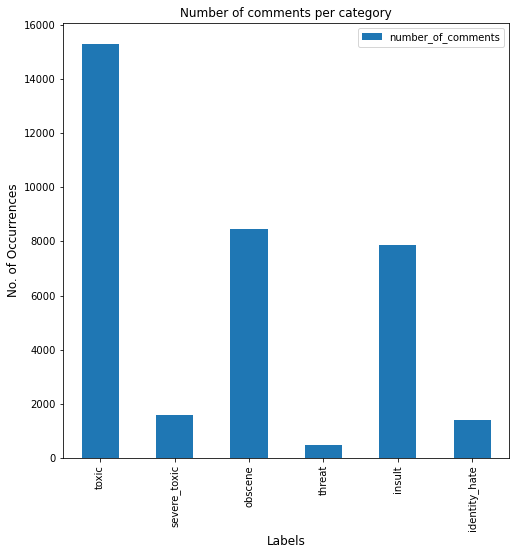

In [12]:
### Visualization 1

### Bar graph of total number of comments per label 
### This visualization is helpful in identifying the total number of comments per label
dataframe.plot(x='Labels', y='number_of_comments', kind='bar',figsize=(8,8))
plt.title("Number of comments per category")
plt.ylabel('No. of Occurrences', fontsize=12)
plt.xlabel('Labels', fontsize=12)

### From the below graph we can observe that most of the comments having toxic label. 
### Threat label is having lowest no. of comments

,0,Total no. of sentences,Total No. of labels in a sentence
0,143346,143346,0
1,6360,6360,1
3,4209,4209,3
2,3480,3480,2
4,1760,1760,4
5,385,385,5
6,31,31,6


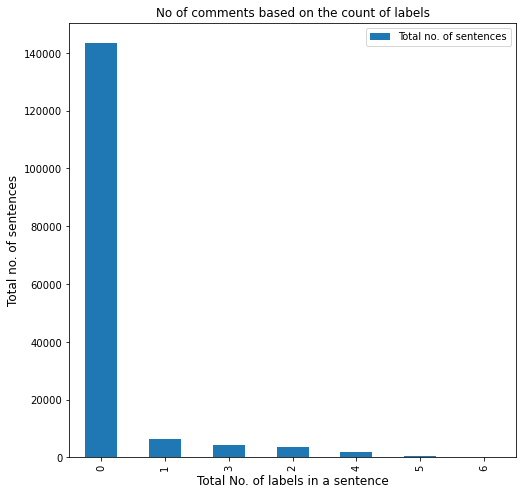

In [13]:
### Visualization 2

### Bar graph of Total No. of labels in a sentence against Total no. of sentences
### This visualization is helpful in identifying whether a sentence belongs to only one category or many categories

dataframe = pd.DataFrame(pd.DataFrame(train[train.columns[2:]].sum(axis=1)).reset_index()[0].value_counts())
dataframe["Total no. of sentences"]=dataframe[0]
dataframe["Total No. of labels in a sentence"]=dataframe.index
dataframe.plot(x="Total No. of labels in a sentence", y="Total no. of sentences", kind='bar',figsize=(8,8))
plt.title("No of comments based on the count of labels")
plt.ylabel('Total no. of sentences', fontsize=12)
plt.xlabel('Total No. of labels in a sentence', fontsize=12)
dataframe

### From the below graph we can see that 1,43,346 out of 1,59,571 sentences does not have any labels(class 0).
### we can observe that a single sentence can have multiple labels. It can be a toxic sentence or it can be a toxic as well as obscene senetence.

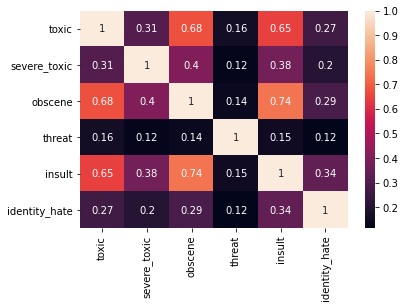

In [14]:
### Visualization 3

### Correlation between different variables
### Correlation helps us finding relationship/dependency between different variables. 

target_data = train.drop(['id', 'comment_text'], axis=1)
corrMatrix = target_data.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

### Correlation coefficient ranges from -1 to 1. Values always range between -1 imply strong negative relationship
### between variables and +1 imply a strong positive relationship between variables. 
### Values at or close to zero imply weak or no linear relationship. 
### From the correlation matrix(graph), it can be concluded that some labels are highely correlated. Those varibles are mentioned below 
### (Correlation coefficient for insult-obscene is 0.74, Correlation coefficient for toxic-obscene is 0.68 and Correlation coefficient for toxic-insult is 0.65).

In [15]:
### From visualization we can conclude following things
### 1) A single sentence can have multiple labels (categories)
### 2) Some labels are highely correlated to each other
### 3) This is multi label classification problem 

In [16]:
# model_type: word2vec, glove or fasttext
aug_w2v = naw.WordEmbsAug(
#     model_type='word2vec', model_path='../input/nlpword2vecembeddingspretrained/GoogleNews-vectors-negative300.bin',
    model_type='glove', model_path='../data/glove.6B/glove.6B.100d.txt',
    action="substitute")

In [17]:
text = 'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [18]:
aug_w2v.aug_p=0.2
print("Augmented Text:")
for ii in range(5):
    augmented_text = aug_w2v.augment(text)
    print(augmented_text)

Augmented Text:
Our Deeds are well Reason including this # earthquake May ALLAH Forgive us all
Our Deeds are only Reason of this # earthquake May ALLAH Forgive now all
Our Deeds are the Reason first this # earthquake May ALLAH Forgive us fact
Our Deeds are the Reason of this # cyclone May ALLAH Forgive us once
Our Deeds are place Reason of this # earthquake May ALLAH Forgive us so


In [19]:
def augment_text(df,samples=300,pr=0.2):
    aug_w2v.aug_p=pr
    new_text=[]
    
    ##dropping samples from validation
    df_n=df[df.severe_toxic==1].reset_index(drop=True)

    ## data augmentation loop
    for i in tqdm(np.random.randint(0,len(df_n),samples)):
        
            text = df_n.iloc[i]['comment_text']
            augmented_text = aug_w2v.augment(text)
            new_text.append(augmented_text)
    
    
    ## dataframe
    new=pd.DataFrame({'comment_text':new_text,'severe_toxic':1})
    df=shuffle(df.append(new).reset_index(drop=True))
    return df

In [21]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [22]:
train_split,valid_split=train_test_split(train,test_size=0.15)

In [25]:
train_split.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
36359,61206ae8b41403b5,in this place with wifi.,0,0,0,0,0,0
158170,e9e2f97a7e9bb987,"No, can't abide laundry lists. Those three ar...",0,0,0,0,0,0
93481,f9f0a212927beec5,Reasonable request \n\nI am going to piss on y...,1,0,0,0,0,0
157734,e2941df731fe4885,"""\n\nWow, you're hopeless. Lets start with th...",0,0,0,0,0,0
121557,8a5c02a396f5b5cc,"""\n\nI do believe that pro se litigation is a ...",0,0,0,0,0,0


In [26]:
train_a = augment_text(train_split,samples=100)   ## change samples to 0 for no augmentation
train_au = train_a.append(valid_split).reset_index(drop=True)

100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


In [37]:
train_au.tail(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159661,f39b28c474efec6b,"[by user:Laomei, removed]",0.0,0,0.0,0.0,0.0,0.0
159662,e008f876ceee22be,Okay I agree it isn't a Pop song but I would c...,0.0,0,0.0,0.0,0.0,0.0
159663,92f9f2951c8132b5,"""\n\nHardly cruel and unusual punishment, a lo...",0.0,0,0.0,0.0,0.0,0.0
159664,4a9d94c99c259435,Hello. I'm glad to be part of Wikipedia. I'm l...,0.0,0,0.0,0.0,0.0,0.0
159665,c60ceafe69f69831,YOU! Talk to the hand!,0.0,0,0.0,0.0,0.0,0.0
159666,f22f474b2f5abc76,"""\ntsk tsk ..We lose a lot of Good Editors and...",0.0,0,0.0,0.0,0.0,0.0
159667,006a4cdda4960588,friesers opinion is simple i guess. kursk was ...,0.0,0,0.0,0.0,0.0,0.0
159668,402e8582983417ba,"Deepwater deaths \n\nHi, i noticed you were pa...",0.0,0,0.0,0.0,0.0,0.0
159669,9c6ae200ccba4cd1,I think it would be better if the SkyCable log...,0.0,0,0.0,0.0,0.0,0.0
159670,33ad65f88b9026bb,CfD\nHi. Under the circumstances I think it mi...,0.0,0,0.0,0.0,0.0,0.0


In [32]:
### Before cleaning the dataset I would like to perform EDA(Exploratory data analysis) by performing data visualization to understand
### the distribution of different classes. I will be performing EDA on training dataset

categorywise_data = train_au.drop(['id', 'comment_text'], axis=1)     ### Removed unnecessary columns - id and comment_text
counts_category = []                                               ### A list that contains tuple which consists of class label and number of comments for that particular class 
categories = list(categorywise_data.columns.values)
for i in categories:
    counts_category.append((i, categorywise_data[i].sum()))
    
dataframe = pd.DataFrame(counts_category, columns=['Labels', 'number_of_comments'])   ### Dataframe made up of category and total number of comments

Text(0.5, 0, 'Labels')

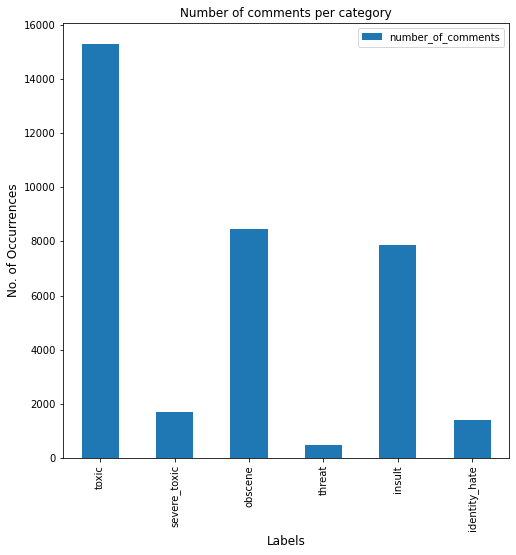

In [33]:
### Visualization 1

### Bar graph of total number of comments per label 
### This visualization is helpful in identifying the total number of comments per label
dataframe.plot(x='Labels', y='number_of_comments', kind='bar',figsize=(8,8))
plt.title("Number of comments per category")
plt.ylabel('No. of Occurrences', fontsize=12)
plt.xlabel('Labels', fontsize=12)

### From the below graph we can observe that most of the comments having toxic label. 
### Threat label is having lowest no. of comments

In [34]:
# Remove the Stop world
# Convert everything to lower case
# Remove special characters and punctuations
# Remove wordds that have lwss than 3 charecters
# =============

stemmer = nltk.SnowballStemmer("english")
stop_words = set(stopwords.words('english'))
def preprocess(string):
    string = string.lower() # Convert everything to lower case.
    string = re.sub('[^A-Za-z0-9]+', ' ', string) # Remove special characters and punctuations
    string = re.sub(r'\b\w{1,3}\b', ' ', string) # Remove words that have less than 3 characters
    
    x = string.split()
    new_text = []
    
    for word in x:
        if word not in stop_words: # Remove stop worlds
            new_text.append(stemmer.stem(word))
            
    string = ' '.join(new_text)
    return string

In [35]:
%%time
train['preprocessed_text'] = train['comment_text'].apply(preprocess) # Compute the train prepossing time

CPU times: user 1min 46s, sys: 1.23 s, total: 1min 48s
Wall time: 1min 55s


In [36]:
%%time
test['preprocessed_text'] = test['comment_text'].apply(preprocess) # Compute the test prepossing time

CPU times: user 1min 29s, sys: 789 ms, total: 1min 29s
Wall time: 1min 33s


In [38]:
# train test split
# ================

train_aug = train[['preprocessed_text']]
train_label = train[['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']]
test_aug = test[['preprocessed_text']]
#X_train, X_validation, y_train, y_validation = train_test_split(train_full, train_label, shuffle = True, random_state = 123)

In [39]:
# Saving the files to csv so that we dont need to preprocess again.
# =====================

train_aug.to_pickle('train_aug.pkl')
test_aug.to_pickle('test_aug.pkl')

In [40]:
# To load the csv files:
# =============

train_data = pd.read_pickle('train_aug.pkl')
test_data = pd.read_pickle('test_aug.pkl')

### 3. Features for LSTM and GRU:

In [41]:
class Featurization:
    
    def __init__(self):
        self.word_mapping = None
        self.total_words = None
        
    
    # Accepts a list of sentences and builds a vocabulary.
    def build_vocabulary(self, sentences):
        
        vocab = set()
        for x in sentences:
            for word in x.split():
                vocab.add(word)
        
        # Create a dictionary from vocabulary.
        vocab_dict = dict.fromkeys(vocab, 0)
        
        # Calculate count of each word..
        for x in sentences:
            for word in x.split():
                vocab_dict[word]+=1
                
        return vocab_dict
    
    
    
    # Accepts a dictionary (vocabulary) and gets the word number in dictionary format
    def get_mapping(self, vocab_dict):
                
        # Get the number of each word into the corpus.
        k = []
        v = []
        for keys,val in vocab_dict.items():
            k.append(keys)
            v.append(val)
            
        kv = np.vstack((k,v)).T
        df = pd.DataFrame(columns=["Word","Count"], data=kv)
        df['Count'] = df['Count'].astype('int')
        
        # Sort the dataframe to get the largest count at first place
        df.sort_values(by=['Count'], ascending=False, inplace=True)
        
        # Give numbering to the most frequent word as 1 then next as 2 and so on.
        df.reset_index(inplace=True)
        df['mapping'] = df.index + 1
        
        df.drop(columns=['index'], inplace=True)
        df.drop(columns=['Count'], inplace=True)
        
        # Convert to dictionary for easier processing.
        dictionary = dict(zip(df['Word'], df['mapping']))
        
        return dictionary
    
    
    # Accepts a list of sentences and generates vocabulary and word mappings.
    def fit(self, sentences):
        v = self.build_vocabulary(sentences)
        self.word_mapping = self.get_mapping(v)
        self.total_words = len(self.word_mapping)
        
    # Converts the sentences to number mappings.
    def transform(self, sentences, pad_length = 150):
        
        whole = list() # Stores mapping for all sentences
        for x in sentences: # for each sentence in list of sentences.
            
            part = list()
            for word in x.split(): # for each word
                if word in self.word_mapping:
                    part.append(self.word_mapping[word]) # Append mapped number.
            whole.append(part) # Append sentence.

        # Append additional values to make lengths equal.
        nparray = np.array(whole, dtype="object")
        whole = keras.preprocessing.sequence.pad_sequences(nparray, maxlen=pad_length)
        
        return whole

In [42]:
featurization = Featurization()
featurization.fit(train_data['preprocessed_text'])

In [43]:
train_padded = featurization.transform(train_data['preprocessed_text'])
test_padded = featurization.transform(test_data['preprocessed_text'])

In [44]:
# create the model with Two LSTM layer
# ===============

embedding_vecor_length = 100
total_words = featurization.total_words
model = Sequential()
#model.add(Embedding(total_words+1 ,embedding_vecor_length, input_length=150))
model.add(Embedding(total_words+1 ,embedding_vecor_length))
model.add(LSTM(units = 64, dropout = 0.2, return_sequences=True))
model.add(LSTM(units = 64, dropout = 0.2))
model.add(Dense(units = 6, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         13769200  
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          42240     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
Total params: 13,844,854
Trainable params: 13,844,854
Non-trainable params: 0
_________________________________________________________________
None


In [45]:
X_train, X_validation, y_train, y_validation = train_test_split(train_padded, train_label, shuffle = True, random_state = 123)

In [46]:
# Fit the model 
# ===========

history = model.fit(
                    X_train, 
                    y_train, 
                    epochs=1,
                    batch_size=1000, 
                    validation_data=(X_validation, y_validation),
                    verbose = 1, 
                )

120/120 [==============================] - 299s 2s/step - loss: 0.3027 - auc: 0.5945 - val_loss: 0.1384 - val_auc: 0.7602


In [47]:
# create the model with two GRU layer
# =========

embedding_vecor_length = 100
total_words = featurization.total_words
model1 = Sequential()
#model1.add(Embedding(total_words+1 ,embedding_vecor_length, input_length=150))
model1.add(Embedding(total_words+1 ,embedding_vecor_length))
model1.add(GRU(units = 64, dropout = 0.2, return_sequences=True))
model1.add(GRU(units = 64, dropout = 0.2))
model1.add(Dense(units = 6, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])
print(model1.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         13769200  
_________________________________________________________________
gru (GRU)                    (None, None, 64)          31872     
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                24960     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
Total params: 13,826,422
Trainable params: 13,826,422
Non-trainable params: 0
_________________________________________________________________
None


In [48]:
# callback function, we can save the model best weight and 
filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(
                    filepath, 
                    monitor='val_loss', 
                    verbose=1, 
                    save_best_only=True, 
                    mode='max'
                )
callbacks_list = [checkpoint]

In [50]:
history1 = model1.fit(
                    X_train, 
                    y_train, 
                    epochs=5,
                    batch_size=500, 
                    validation_data=(X_validation, y_validation),
                    verbose = 1, 
                    callbacks=callbacks_list
                )

Epoch 1/5
240/240 [==============================] - 293s 1s/step - loss: 0.0570 - auc: 0.9744 - val_loss: 0.0551 - val_auc: 0.9747

Epoch 00001: val_loss did not improve from 0.06287
Epoch 2/5
240/240 [==============================] - 301s 1s/step - loss: 0.0472 - auc: 0.9813 - val_loss: 0.0530 - val_auc: 0.9717

Epoch 00002: val_loss did not improve from 0.06287
Epoch 3/5
240/240 [==============================] - 292s 1s/step - loss: 0.0420 - auc: 0.9853 - val_loss: 0.0548 - val_auc: 0.9723

Epoch 00003: val_loss did not improve from 0.06287
Epoch 4/5
240/240 [==============================] - 298s 1s/step - loss: 0.0382 - auc: 0.9877 - val_loss: 0.0558 - val_auc: 0.9649

Epoch 00004: val_loss did not improve from 0.06287
Epoch 5/5
240/240 [==============================] - 289s 1s/step - loss: 0.0352 - auc: 0.9894 - val_loss: 0.0576 - val_auc: 0.9622

Epoch 00005: val_loss did not improve from 0.06287


In [ ]:
predict = model1.predict(test_padded)

In [ ]:
# predicted probabilities of each comment text in the test set, for all the target columns
# =============

target_cols = np.array(['toxic','severe_toxic','obscene', 'threat','insult', 'identity_hate'])
final_predict_test = pd.concat([pd.DataFrame(predict, columns=target_cols)], 1)
t1 = test['comment_text']
final_predict_test = pd.concat([t1,final_predict_test],1)
final_predict_test.head()